In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, GRU, Activation
from keras.callbacks import TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../train.csv')
print(df.shape)
df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
df_train = df.copy()
df_train['year'] = pd.DatetimeIndex(df_train['datetime']).year
df_train['month'] = pd.DatetimeIndex(df_train['datetime']).month
# df_train['week'] = pd.DatetimeIndex(df_train['datetime']).week
df_train['day'] = pd.DatetimeIndex(df_train['datetime']).day
df_train['dayofweek'] = pd.DatetimeIndex(df_train['datetime']).dayofweek
df_train['hour'] = pd.DatetimeIndex(df_train['datetime']).hour
df_train = df_train.drop('datetime', axis=1)
y_casual = df_train['casual'].copy()
y_registered = df_train['registered'].copy()
df_train = df_train.drop(['casual','registered','count'], axis=1)
x_casual = df_train.copy()
x_registered = df_train.copy()
cr_w_from = 7
cr_w_to = 23
cr_nw_from = 10
cr_nw_to = 19
rr_w_from1 = 7
rr_w_to1 = 9
rr_w_from2 = 12
rr_w_to2 = 21
rr_nw_from = 8
rr_nw_to = 23
x_casual['casual_rush'] = x_casual[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  cr_w_from <= x['hour'] <= cr_w_to)
        or (x['workingday'] == 0 and  cr_nw_from <= x['hour'] <= cr_nw_to)], axis = 1)
x_registered['registered_rush'] = x_registered[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
#         (x['workingday'] == 1 and  rr_w_from1 <= x['hour'] <= rr_w_to2)
        (x['workingday'] == 1 and  (rr_w_from1 <= x['hour'] <= rr_w_to1 or rr_w_from2 <= x['hour'] <= rr_w_to2))
        or (x['workingday'] == 0 and rr_nw_from <= x['hour'] <= rr_nw_to)], axis = 1)
print(x_casual.shape, x_registered.shape)
x_casual.head()

(10886, 14) (10886, 14)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour,casual_rush
0,1,0,0,1,9.84,14.395,81,0.0,2011,1,1,5,0,0
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,5,1,0
2,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,5,2,0
3,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,5,3,0
4,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,5,4,0


In [4]:
def reshape_data(x, y, look_back=1):
    dataX, dataY = [], []
    for i in np.arange(len(y)-look_back):
        dataX.append(x[i:(i+look_back)])
        dataY.append(y[i + look_back])
    return np.array(dataX), np.array(dataY)

def reshape_pred(x, look_back=1):
    dataX = []
    for i in np.arange(len(x)-look_back+1):
        dataX.append(x[i:(i+look_back)])
    return np.array(dataX)

In [ ]:
X = x_registered.values
Y = y_registered.values
n_features = X.shape[1]
time_steps = 4
scaler_reg = StandardScaler()
X = scaler_reg.fit_transform(X)
# X = X.reshape(X.shape[0], time_steps, n_features)
X, Y = reshape_data(X, Y, time_steps)
def new_model():
    # create model
    model = Sequential()
    model.add(GRU(100, input_shape=(time_steps, n_features), return_sequences=True, activation='relu'))
    model.add(GRU(100, input_shape=(time_steps, n_features), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.add(Activation('linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='RMSprop')
    return model
kr_registered = KerasRegressor(build_fn=new_model, nb_epoch=100, batch_size=5, verbose=2)
%time kr_registered.fit(X, Y, callbacks=[TensorBoard(log_dir='logs/reg_gru2dense4_ts4_'+datetime.now().strftime("%Y%m%d-%H%M"))])
X = x_casual.values
Y = y_casual.values
n_features = X.shape[1]
scaler_cas = StandardScaler()
X = scaler_cas.fit_transform(X)
# X = X.reshape(X.shape[0], 1, n_features)
X, Y = reshape_data(X, Y, time_steps)
kr_casual = KerasRegressor(build_fn=new_model, nb_epoch=100, batch_size=5, verbose=2)
%time kr_casual.fit(X, Y, callbacks=[TensorBoard(log_dir='logs/cas_gru2dense4_ts4_'+datetime.now().strftime("%Y%m%d-%H%M"))])

## Prediction

In [183]:
df_test = pd.read_csv('../test.csv')
print(df_test.shape)
df_test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [184]:
df1 = df.drop(['casual','registered','count'], axis=1)
dft = df_test.copy()
for year in [2011,2012]:
    for i in np.arange(1,13):
        m = str(i) if i>9 else '0'+str(i)
        insert_index = dft[dft['datetime'] == str(year)+'-'+m+'-20 00:00:00'].index[0]
        line = df1[df1['datetime'] == str(year)+'-'+m+'-19 23:00:00']
        dft = pd.concat([dft.ix[:insert_index-1], line, dft.ix[insert_index:]]).reset_index(drop=True)
# dft[insert_index-2:insert_index+2]
dft.shape

(6517, 9)

In [185]:
# dft = df_test.copy()
dft['year'] = pd.DatetimeIndex(dft['datetime']).year
dft['month'] = pd.DatetimeIndex(dft['datetime']).month
# dft['week'] = pd.DatetimeIndex(dft['datetime']).week
dft['day'] = pd.DatetimeIndex(dft['datetime']).day
dft['dayofweek'] = pd.DatetimeIndex(dft['datetime']).dayofweek
dft['hour'] = pd.DatetimeIndex(dft['datetime']).hour
dft = dft.drop('datetime', axis=1)
t_casual = dft.copy()
t_registered = dft.copy()
t_casual['casual_rush'] = t_casual[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  cr_w_from <= x['hour'] <= cr_w_to)
        or (x['workingday'] == 0 and  cr_nw_from <= x['hour'] <= cr_nw_to)], axis = 1)
t_registered['registered_rush'] = t_registered[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  (rr_w_from1 <= x['hour'] <= rr_w_to1 or rr_w_from2 <= x['hour'] <= rr_w_to2))
        or (x['workingday'] == 0 and rr_nw_from <= x['hour'] <= rr_nw_to)], axis = 1)
print(t_casual.shape, t_registered.shape)
t_casual.head()

(6517, 14) (6517, 14)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour,casual_rush
0,1,0,1,1,12.30,13.635,52,31.0009,2011,1,19,2,23,1
1,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,3,0,0
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,1,0
3,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,2,0
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3,0


In [186]:
# t_casual = scaler_cas.fit_transform(t_casual)
# t_registered = scaler_reg.fit_transform(t_registered)
# t_casual = pd.DataFrame(scaler_cas.fit_transform(t_casual), columns=t_casual.columns)
# t_registered = pd.DataFrame(scaler_reg.fit_transform(t_registered), columns=t_registered.columns)
# t_casual = t_casual.reshape(t_casual.shape[0], time_steps, n_features)
# t_casual = reshape_pred(t_casual, time_steps)
# t_registered = t_registered.reshape(t_registered.shape[0], time_steps, n_features)
# t_registered = reshape_pred(t_registered, time_steps)
t_cas = np.zeros((t_casual.shape[0]-24, time_steps, t_casual.shape[1]))
t_reg = np.zeros((t_registered.shape[0]-24, time_steps, t_registered.shape[1]))
c = 0
for year in [2011,2012]:
    for i in np.arange(1,13):
        rs = reshape_pred(t_casual[(t_casual['year']==year) & (t_casual['month']==i)].values, time_steps)
        c += len(rs)
        t_cas[c-len(rs):c] = rs
        rs = reshape_pred(t_registered[(t_registered['year']==year) & (t_registered['month']==i)].values, time_steps)
        t_reg[c-len(rs):c] = rs
t_cas_scaled = np.zeros((t_cas.shape))
t_reg_scaled = np.zeros((t_reg.shape))
for i in np.arange(len(t_cas)):
    t_cas_scaled[i] = scaler_cas.transform(t_cas[i])
    t_reg_scaled[i] = scaler_reg.transform(t_reg[i])
test_pred_casual = kr_casual.predict(t_cas_scaled)
test_pred_casual[test_pred_casual < 0] = 0
test_pred_registered = kr_registered.predict(t_reg_scaled)
test_pred_registered[test_pred_registered < 0] = 0
test_pred = test_pred_casual + test_pred_registered
str_prediction = "datetime,count\n"
for i in range(0, len(test_pred)):
    datetime = df_test['datetime'][i]
    pred = int(round(test_pred[i]))
    str_prediction += "{},{}\n".format(datetime, pred)

# print(str_prediction)
f = open('pred_keras_gru.csv','w')
f.write(str_prediction)
f.close()

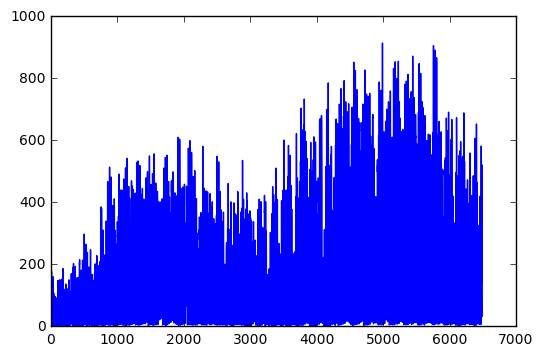

In [187]:
plt.plot(test_pred)

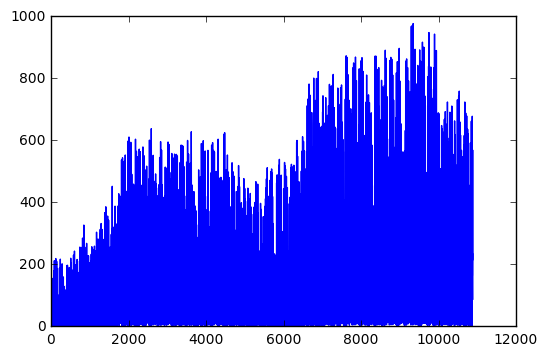

In [188]:
plt.plot(df['count'])